# Redes convolucionales

Las redes convolucionales se basan en la operación de convolución que se usa para obtener información local de los datos. Su principal aplicación es en imágenes donde cada pixel tiene que ver con los pixeles de su vecindad.

Una convolución es una combinación de la imagen y una matríz llamada **filtro**. Un filtro tiene un tamaño típico de 3x3 ó 5x5 pixeles, mientras que las imágenes son mucho más grandes. El filtro hace un barrido sobre los pixeles de la imagen aplicando la operación de multiplicación (coordenada a coordenada) seguida de la suma.

El resultado de una convolución es una transformación de la imagen llamada **mapa de activación**. Diferentes filtros producen diferentes mapas de activación que se pueden volver a transformar usando otros filtros para obtener tranformaciones más complejas. Estos mapas de activación se pueden ver como características extraídas de las imágenes.

Al final, los mapas de acitvación se *aplanan* para convertirlos en un vector y luego aplicar capas densas antes de hacer la predicción.

Para correr este notebook se necesitarán los archivos:
- house.jpg
- PetImages_small.zip

## 🔴⚠️ Importante ⚠️🔴

Se recomienda usar una GPU para ejecutar este notebook. En el menú **Entorno de ejecución**, elegir Cambiar tipo de entorno de ejecución y en la sección **Acelerador por hardware** elegir una GPU o TPU.

In [1]:
!wget geo.ingeotec.mx/~lgruiz/MeIA/PetImages_small.zip
!wget geo.ingeotec.mx/~lgruiz/MeIA/house.jpg

--2025-06-02 15:45:26--  http://geo.ingeotec.mx/~lgruiz/MeIA/PetImages_small.zip
Resolving geo.ingeotec.mx (geo.ingeotec.mx)... 189.254.229.114
Connecting to geo.ingeotec.mx (geo.ingeotec.mx)|189.254.229.114|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 386340140 (368M) [application/zip]
Saving to: ‘PetImages_small.zip’

PetImages_small.zip 100%[===================>] 368.44M  2.03MB/s    in 2m 17s  

2025-06-02 15:47:43 (2.69 MB/s) - ‘PetImages_small.zip’ saved [386340140/386340140]

--2025-06-02 15:47:43--  http://geo.ingeotec.mx/~lgruiz/MeIA/house.jpg
Resolving geo.ingeotec.mx (geo.ingeotec.mx)... 189.254.229.114
Connecting to geo.ingeotec.mx (geo.ingeotec.mx)|189.254.229.114|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39019 (38K) [image/jpeg]
Saving to: ‘house.jpg’

house.jpg           100%[===================>]  38.10K  --.-KB/s    in 0.06s   

2025-06-02 15:47:43 (676 KB/s) - ‘house.jpg’ saved [39019/39019]



## Ejemplos de convoluciones

En el siguiente ejemplo tenemos la matriz `A` y se la aplicará el filtro `f`.

In [2]:
from scipy.ndimage import correlate
import numpy as np

In [3]:
A = np.array([[4,1,7,2,3], [8,3,1,2,2], [6,5,7,4,3], [2,2,3,1,3],[4,3,4,2,3]])
A

array([[4, 1, 7, 2, 3],
       [8, 3, 1, 2, 2],
       [6, 5, 7, 4, 3],
       [2, 2, 3, 1, 3],
       [4, 3, 4, 2, 3]])

In [4]:
f = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
f

array([[ 1,  0, -1],
       [ 1,  0, -1],
       [ 1,  0, -1]])

In [5]:
correlate(A, f, mode='constant')

array([[ -4,   4,   0,   3,   4],
       [ -9,   3,   1,   7,   8],
       [-10,   5,   3,   3,   7],
       [-10,  -2,   3,   5,   7],
       [ -5,  -1,   2,   1,   3]])

## Ejemplo con imágenes

Ahora veamos el efecto de aplicar una convolución a una imagen en lugar de una matriz.

In [6]:
from skimage.io import imread
import matplotlib.pyplot as plt

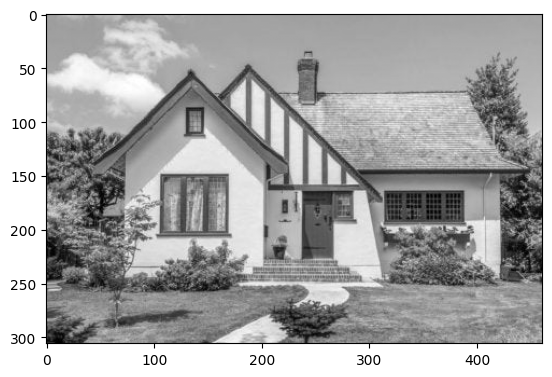

In [7]:
img = imread("house.jpg", as_gray=True)
plt.imshow(img, cmap='gray')
plt.show()

El siguiente kernel se usa para detectar bordes horizontales.

In [8]:
f = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
f

array([[-1,  0,  1],
       [-1,  0,  1],
       [-1,  0,  1]])

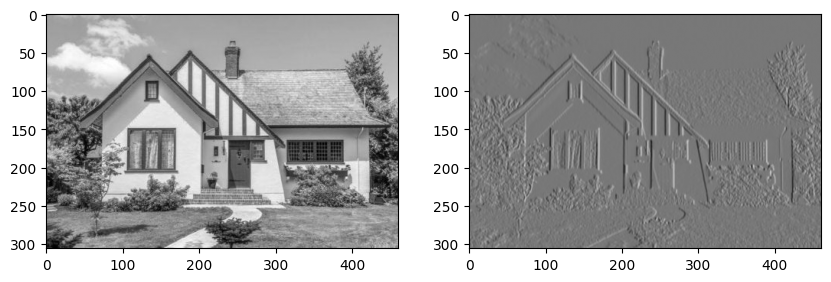

In [9]:
T = correlate(img, f, mode='constant')
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(T, cmap='gray')
plt.show()

También se puede *voltear* para obtener un kernel que identifique bordes verticales. Note las diferencias en los mapas de activación.

In [10]:
f = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])
f

array([[-1, -1, -1],
       [ 0,  0,  0],
       [ 1,  1,  1]])

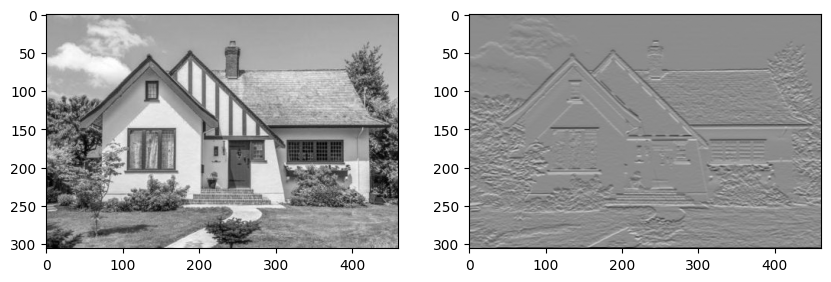

In [11]:
T = correlate(img, f, mode='constant')
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(T, cmap='gray')
plt.show()

El siguiente filtro resalta los bordes y elimina todo lo demás.

In [12]:
f = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
f

array([[-1, -1, -1],
       [-1,  8, -1],
       [-1, -1, -1]])

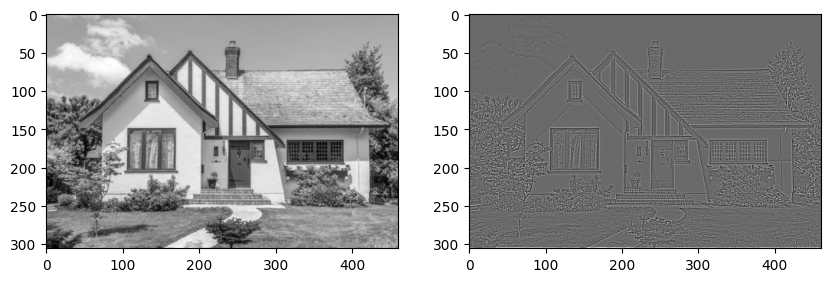

In [13]:
T = correlate(img, f, mode='constant')
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(T, cmap='gray')
plt.show()

## Pooling

La operación de pooling permite trabajar con mapas de activación más pequeños. Lo más común es dividir los mapas a la mitad en alto y ancho, logrando una reducción del 75% del tamaño en pixeles. Esto permite trabajar con mapas más pequeños disminuyendo las operaciones necesarias.

In [14]:
from tensorflow.keras import layers

def apply_pooling(A, k=3):
    print("Imagen original:", A.shape)
    max_pool = layers.MaxPooling2D((2, 2))
    avg_pool = layers.AveragePooling2D((2, 2))

    B = A.copy()
    C = A.copy()
    for i in range(k):
        B = max_pool(B)
        C = avg_pool(C)
        plt.figure(figsize=(8, 8))
        plt.subplot(k,2,1)
        plt.imshow(B[0,:,:,0], cmap='gray')
        plt.title(f"Max pooling {B.shape}")

        plt.subplot(k,2,2)
        plt.imshow(C[0,:,:,0], cmap='gray')
        plt.title(f"Average pooling {C.shape}")

        plt.show()

Imagen original: (1, 306, 461, 1)


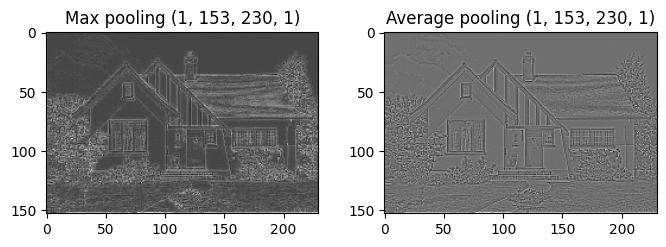

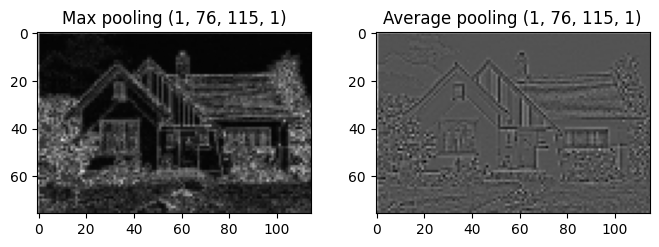

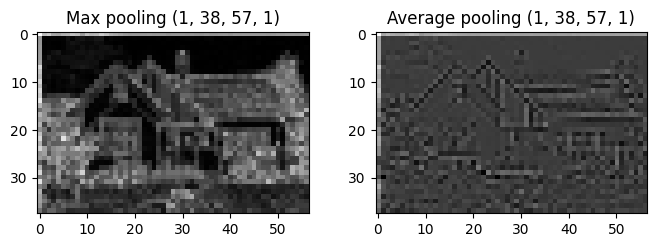

In [15]:
apply_pooling(T.reshape(1, T.shape[0], T.shape[1], 1))

## Ejemplo de Perros y gatos

Ahora veremos un ejemplo de como se usa la operación convolución en una red neuronal para clasificar imágenes de perros y gatos. Las primeras capas de la red serán de convolución seguidas de MaxPooling y al final una capa densa para hacer la clasificación.

Primero debemos obtener el conjunto de datos que están en el archivo `PetImages_small.zip`. Después de descomprimir, se leerán las imágenes usando la función `ImageDataGenerator`.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers


In [ ]:
!unzip -q PetImages_small.zip

Se reescalan las imágenes para que tengan valores entre 0 y 1. Se dividen los datos en 80% entrenamiento y 20% validación.

In [ ]:
datagen = ImageDataGenerator(rescale=1./255,
                             validation_split=0.2,
                            )

Se leen las imágenes del directorio PetImages. Las etiquetas se obtienen de los subdirectorios.

In [ ]:
train_generator = datagen.flow_from_directory("PetImages/",
                                              target_size=(150, 150),
                                              batch_size=128,
                                              class_mode='binary',
                                              seed=42,
                                              shuffle=True,
                                              subset="training")

Found 9601 images belonging to 2 classes.


In [ ]:
val_generator = datagen.flow_from_directory("PetImages",
                                            target_size=(150, 150),
                                            batch_size=128,
                                            class_mode='binary',
                                            seed=42,
                                            shuffle=False,
                                            subset="validation")

Found 2400 images belonging to 2 classes.


Aquí se crea la estructura de la red convolucional. La primera capa es de convolución (Conv2D) tiene 32 filtros de 3x3 con una activación ReLU. El tamaño de las imágenes de entreada es de 150x150 pixeles en los 3 canales (RGB). Luego viene una capa de MaxPooling que divide a la mitad las dimensiones de los mapas de activación.

Siguen 3 bloque de capas de convolución seguidas de una MaxPooling.

Se aplanan los mapas de activación que entran a una capa densa de 128 neuronas.

La salida de la red es una neurona, que se usará para hacer la predicción.

In [ ]:
model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 18, 18, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 5184)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 5184)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       663,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 830,849 (3.17 MB)

 Trainable params: 830,849 (3.17 MB)

 Non-trainable params: 0 (0.00 B)

Note que la primera capa de convolución tiene una salida de 32 mapas de activación (de 150x150). La resolución de los mapas de activación se va reduciendo a la mitad hasta llegar a los 9x9 pixeles. Al final, se tienen 9x9x64 = 5184 dimensiones del vector aplanado.

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=.001),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=10)

Epoch 1/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 45s 455ms/step - accuracy: 0.5562 - loss: 0.6724 - val_accuracy: 0.5725 - val_loss: 0.6803
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 68s 388ms/step - accuracy: 0.6182 - loss: 0.6442 - val_accuracy: 0.6879 - val_loss: 0.5957
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 28s 369ms/step - accuracy: 0.6903 - loss: 0.5871 - val_accuracy: 0.7404 - val_loss: 0.5275
Epoch 4/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 40s 355ms/step - accuracy: 0.7397 - loss: 0.5202 - val_accuracy: 0.7521 - val_loss: 0.4958
Epoch 5/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 40s 347ms/step - accuracy: 0.7372 - loss: 0.5287 - val_accuracy: 0.7692 - val_loss: 0.4890
Epoch 6/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 27s 358ms/step - accuracy: 0.7749 - loss: 0.4582 - val_accuracy: 0.7779 - val_loss: 0.4709
Epoch 7/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 27s 356ms/step - accuracy: 0.7876 - loss: 0.4464 - val_accuracy: 0.7900 - val_loss: 0.4475
Epoch 8/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 27s 349ms/step - accuracy: 0.8001 - loss: 0.4321 - val_accu

Guardamos el modelo para usarlo después.

In [ ]:
model.save("cnn-dogs-cats.keras")

Luego lo podemos leer con:

```
from tensorflow.keras.models import load_model
model = load_model("cnn-dogs-cats.keras")
```

## Mostrar algunas predicciones

A continuación vamos a mostrar algunas de las imágenes y cómo fueron clasificadas por la red convolucional. Las imágenes fueron tomadas del conjunto de validación.

In [ ]:
test_generator = datagen.flow_from_directory("PetImages",
                                            target_size=(150, 150),
                                            batch_size=8,
                                            class_mode='binary',
                                            seed=42,
                                            shuffle=True,
                                            subset="validation")

Found 2400 images belonging to 2 classes.


In [ ]:
for batch in test_generator:
    break
images = batch[0]
predictions = model.predict(images)
predictions.shape



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step


(8, 1)

Usando `class_indices` podemos saber las clases y su etiqueta numérica.

In [ ]:
test_generator.class_indices

{'Cat': 0, 'Dog': 1}

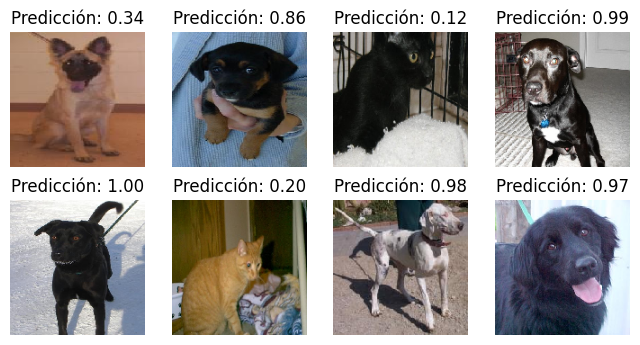

In [ ]:
c = 0
fig = plt.figure(figsize=(8, 4))
for im, p in zip(images, predictions):
    c += 1
    fig.add_subplot(2, 4, c)
    plt.axis('off')
    plt.imshow(im)
    plt.title(f"Predicción: {p[0]:.2f}")
plt.show()

## Ejercicio

Modificar la configuración de la red para obtener el mayor accuracy posible. **Dejar el parámetro de 10 epochs fijo.** Los cambios que se sugieren son:
- Cambiar el número de filtros por capa Conv2D.
- Cambiar el tamaño del filtro. Usar 3x3 o 5x5.
- Modificar la cantidad de capas convolucionales de la red.
- Cambiar el número de neuronas de la capa densa.
- Cambiar el learning rate.
- Probar con diferentes tamaños de lote (`batch_size`).
